# EMBARCATECH

# ATIVIDADE 28 - EMBARCATECH
## Equipe: Camila De Araújo Bastos, Jackson Silva dos Santos, Lucas Carneiro de Araújo Lima, Luis Felipe Pereira de Carvalho, Mariana da Silva Lima Santos

In [1]:
# ============================================================
# 0) Imports básicos
# ============================================================
# TensorFlow: framework de ML que vamos usar para:
#   - carregar o dataset MNIST
#   - definir e treinar a CNN
#   - converter o modelo para TFLite (INT8) para embarcar no Pico W
import tensorflow as tf

# NumPy: biblioteca para manipular arrays e fazer conversões/reshape
import numpy as np

In [2]:
# ------------------------------------------------------------
# 1) carregar dataset
# ------------------------------------------------------------
# MNIST: imagens 28x28 (tons de cinza) de dígitos manuscritos (0 a 9).
# Retorna:
#   x_train: (60000, 28, 28) pixels uint8 (0..255)
#   y_train: (60000,) rótulos 0..9
#   x_test : (10000, 28, 28)
#   y_test : (10000,)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalização:
# - Modelos de rede neural treinam melhor com entradas em float e faixa pequena.
# - Aqui a gente faz: pixel_float = pixel_uint8 / 255.0  => faixa [0.0 .. 1.0]
# - Também adicionamos um canal (.., None) para ficar no formato:
#     [N, 28, 28, 1]2
#   porque Conv2D espera 4D: batch, altura, largura, canais.
x_train = (x_train.astype(np.float32) / 255.0)[..., None]
x_test  = (x_test.astype(np.float32) / 255.0)[..., None]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Formato: (60000, 28, 28, 1) (60000,)


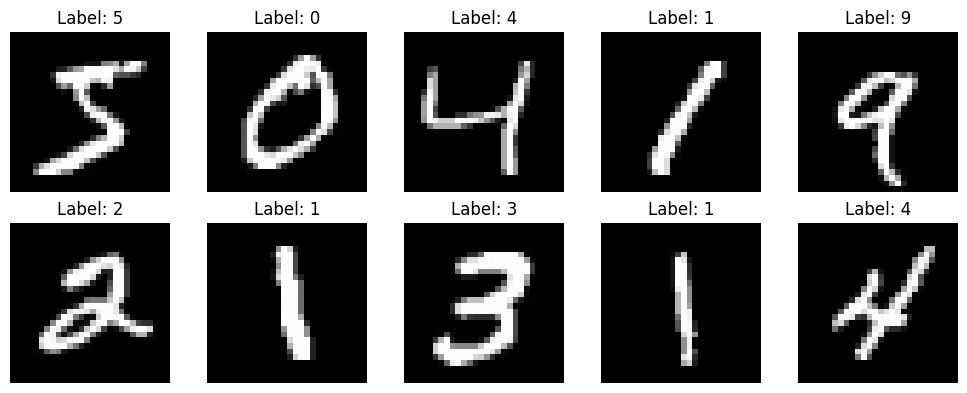

In [3]:
# ------------------------------------------------------------
# 1.1) Exemplos de imagens
# ------------------------------------------------------------
import matplotlib.pyplot as plt

print("Formato:", x_train.shape, y_train.shape)

# Mostrar 10 imagens iniciais do dataset (apenas para inspeção visual)
plt.figure(figsize=(10,4))
for i in range(10):
    # 2 linhas x 5 colunas
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [4]:
# ------------------------------------------------------------
# 2) CNN leve e customizada para TinyML
# ------------------------------------------------------------
# Objetivo:
# Projetar uma CNN com bom desempenho no MNIST, mas adequada a
# ambientes TinyML (ex: Raspberry Pi Pico W + TFLite Micro),
# respeitando limitações de:
#  - memória Flash (número de parâmetros)
#  - custo computacional (MACs)
#  - memória intermediária (tensor arena)
#
# Estratégia geral:
# - Extrair boas características espaciais logo no início da rede
#   usando uma Conv2D "convencional"
# - Reduzir gradualmente a resolução espacial (downsample)
# - Usar convoluções separáveis em profundidade (Depthwise + 1x1) para reduzir custo computacional sem grande perda de acurácia


model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),

    # --------------------------------------------------------
    # Camada 1: Conv2D convencional
    # --------------------------------------------------------
    # Esta camada é responsável por extrair padrões básicos
    # da imagem (bordas, curvas, interseções).
    #
    # Motivo da escolha:
    # - Uma Conv2D tradicional mistura informações espaciais
    #   desde o início, criando uma base de features mais rica.
    #
    # É mantido poucos filtros (8) para não aumentar muito
    # o número de parâmetros.
    tf.keras.layers.Conv2D(8, 3, padding="same", activation="relu"),

    # --------------------------------------------------------
    # Camada 2: Depthwise separable convolution (downsample)
    # --------------------------------------------------------
    # DepthwiseConv2D aplica um filtro por canal, reduzindo
    # drasticamente o número de operações em comparação com
    # Conv2D tradicional.
    #
    # strides=2 realiza o downsample (28x28 -> 14x14),
    # evitando o uso de MaxPooling e reduzindo a memória
    # intermediária.
    tf.keras.layers.DepthwiseConv2D(3, strides=2, padding="same", activation="relu"),

    # Convolução 1x1 (pointwise) para:
    # - combinar os mapas de ativação
    # - aumentar o número de canais (capacidade do modelo)
    tf.keras.layers.Conv2D(16, 1, activation="relu"),

    # --------------------------------------------------------
    # Camada 3: Novo bloco separável com downsample
    # --------------------------------------------------------
    # Repete a estratégia de convolução separável:
    # - DepthwiseConv reduz custo computacional
    # - Conv2D 1x1 aumenta a expressividade
    #
    # Novo downsample: 14x14 -> 7x7
    tf.keras.layers.DepthwiseConv2D(3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(32, 1, activation="relu"),

    # --------------------------------------------------------
    # Global Average Pooling
    # --------------------------------------------------------
    #
    # Calcula a média espacial de cada mapa de ativação,
    # resultando em um vetor pequeno e eficiente.
    #
    # Vantagens:
    # - Reduz drasticamente o número de parâmetros
    # - Menor risco de overfitting
    # - Boa compatibilidade com quantização INT8
    #
    # No TFLite Micro, essa operação é convertida para MEAN,
    # exigindo resolver.AddMean() no firmware.
    tf.keras.layers.GlobalAveragePooling2D(),

    # --------------------------------------------------------
    # Camada de saída
    # --------------------------------------------------------
    # Camada Dense com 10 neurônios, correspondente às
    # classes do MNIST (0 a 9).
    #
    # Softmax produz uma distribuição de probabilidade.
    # Em modelos quantizados INT8, o softmax é aproximado
    # e geralmente utilizado apenas para argmax.
    tf.keras.layers.Dense(10, activation="softmax")
])


In [5]:
# ------------------------------------------------------------
# 2.1) Ajuste de hiperparâmetros para compilação
# ------------------------------------------------------------
# optimizer="adam": bom default para começar
# loss="sparse_categorical_crossentropy":
# porque y_train é rótulo inteiro (0..9) e não one-hot
# metrics=["accuracy"]: para monitorar acurácia durante o treino
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Mostra a arquitetura e número de parâmetros (útil para checar "tamanho")
model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 14, 14, 8)      │            80 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 7, 7, 16)       │           160 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,338 (5.23 KB)

 Trainable params: 1,338 (5.23 KB)

 Non-trainable params: 0 (0.00 B)

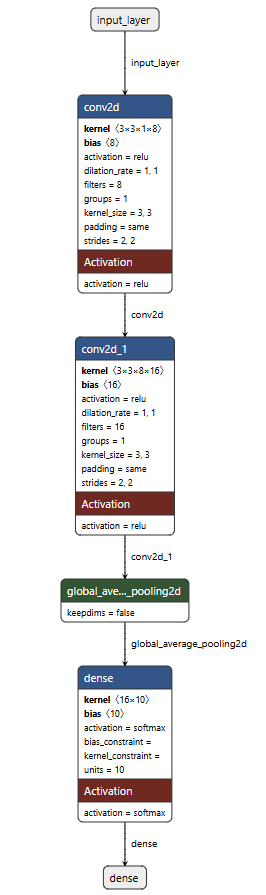

In [6]:
# ------------------------------------------------------------
# 3) Treinar o modelo
# ------------------------------------------------------------
# epochs=75:
# - treina por 75 épocas
# validation_split=0.1:
# - separa 10% do treino para validação (monitorar overfitting)
history = model.fit(x_train, y_train,
                    epochs=75,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/75
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.1489 - loss: 2.2374 - val_accuracy: 0.3650 - val_loss: 1.6908
Epoch 2/75
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4083 - loss: 1.6224 - val_accuracy: 0.5880 - val_loss: 1.2991
Epoch 3/75
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5858 - loss: 1.2795 - val_accuracy: 0.7088 - val_loss: 0.9947
Epoch 4/75
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6828 - loss: 1.0290 - val_accuracy: 0.7702 - val_loss: 0.8074
Epoch 5/75
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7486 - loss: 0.8429 - val_accuracy: 0.8040 - val_loss: 0.6677
Epoch 6/75
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7851 - loss: 0.7260 - val_accuracy: 0.8238 - val_loss: 0.5958
Epoch 7/75
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8062 - loss: 0.6520 - val_accuracy: 0.8445 - val_loss: 0.5390
Epoch 8/75
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8192 - loss: 0.6060 - val_accuracy: 

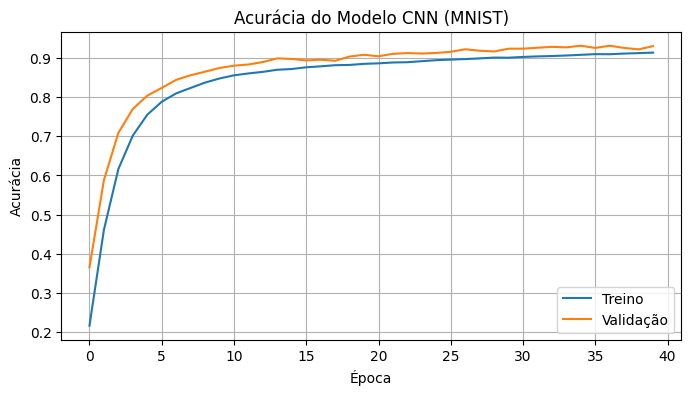

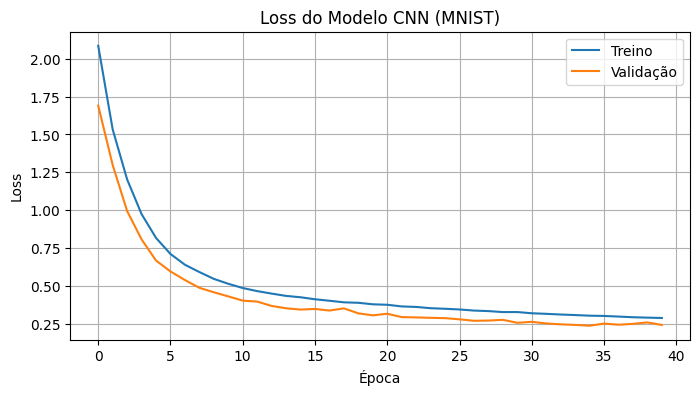

In [7]:
# ------------------------------------------------------------
# 3.1) Avaliação do desempenho de treinamento
# ------------------------------------------------------------
# history.history é um dicionário que contém listas por época:
# - 'accuracy', 'val_accuracy', 'loss', 'val_loss'

# === Acurácia ===
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Acurácia do Modelo CNN (MNIST)')
plt.legend()
plt.grid(True)
plt.show()

# === Loss ===
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Loss do Modelo CNN (MNIST)')
plt.legend()
plt.grid(True)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


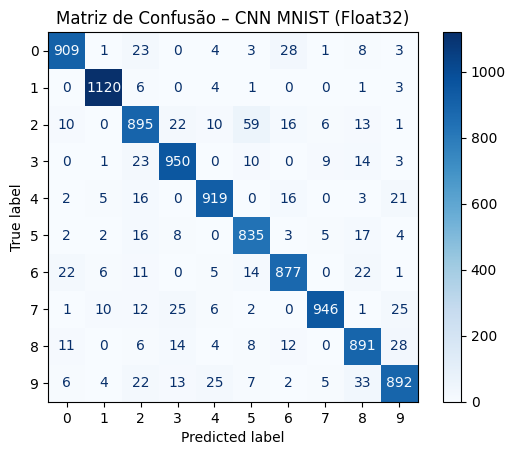

Acurácia final (treino): 91.41%
Acurácia final (validação): 93.07%


In [8]:
# ------------------------------------------------------------
# 3.2) Avaliação do desempenho de classificação - Matrix de Confusão
# ------------------------------------------------------------
# Acurácia sozinha não diz “onde” o modelo erra.
# Matriz de confusão mostra confusões específicas (ex.: 4 confundindo com 9).
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# model.predict(x_test) retorna probabilidades (float) [N, 10]
# argmax -> classe prevista (0..9)
y_pred = np.argmax(model.predict(x_test), axis=1)

# Matriz de confusão
# cm[i, j] = quantidade de exemplos da classe verdadeira i preditos como j
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão – CNN MNIST (Float32)")
plt.show()

# Imprimir as acurácias finais de treino
final_train_acc = history.history['accuracy'][-1]
final_val_acc   = history.history['val_accuracy'][-1]
print(f"Acurácia final (treino): {final_train_acc*100:.2f}%")
print(f"Acurácia final (validação): {final_val_acc*100:.2f}%")

In [9]:
# ============================================================
# 4) Salvar o modelo treinado (Keras)
# ============================================================
# Em versões novas do Keras, é obrigatório:
# - extensão .keras (recomendado)
# - ou .h5
model.save("mnist_cnn_float.keras")

In [10]:
# ------------------------------------------------------------
# 5) Converter para TFLite INT8 (entrada/saída INT8)
# ------------------------------------------------------------
# O ponto crítico da quantização: representative_dataset
# - Serve para calibrar escalas/zer2o_point com dados parecidos com o real.
def rep_data_gen():
    # 200 amostras para calibração já costumam funcionar bem no MNIST.
    # IMPORTANTE: deve ter o mesmo pré-processamento do treino.
    for i in range(200):
        yield [x_train[i:i+1]]

# Converte do modelo Keras para TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Ativa otimizações (inclui quantização)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = rep_data_gen

# Força que as operações e tensores sejam INT8
# - Isso é o cenário típico para microcontroladores (melhor RAM/Flash e velocidade).
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Gera o modelo final (bytes) - Obs.: não tive êxito na RNN
tflite_int8 = converter.convert()

# Salva em disco
open("mnist_cnn_int8.tflite", "wb").write(tflite_int8)
print("TFLite INT8 size (bytes):", len(tflite_int8))

Saved artifact at '/tmp/tmprht5oko9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138199265491664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138199265492432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138199265491472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138199265491856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138199265492624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138199265490704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138199265490128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138199265489552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138199222633488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138199222634064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138199222634256

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


TFLite INT8 size (bytes): 8392


In [11]:
# ------------------------------------------------------------
# 5.1) Converter .tflite em header C (model.h)
# ------------------------------------------------------------
# No Pico W (C/C++), a forma mais simples é embutir o modelo como array de bytes
# dentro do firmware: const unsigned char model[] = { ... };
import binascii

data = open("mnist_cnn_int8.tflite","rb").read()
hexstr = binascii.hexlify(data).decode("ascii")

with open("mnist_cnn_int8_model.h", "w") as f:
    #f.write('#pragma once\n#include <cstdint>\n\n')
    f.write('#pragma once\n#include <stdint.h>\n\n')
    f.write('alignas(16) const unsigned char mnist_cnn_int8_model[] = {\n')
    # Escreve 12 bytes por linha (só para deixar “legível”)
    for i in range(0, len(hexstr), 2*12):
        chunk = hexstr[i:i+2*12]
        bytes_list = [f"0x{chunk[j:j+2]}" for j in range(0, len(chunk), 2)]
        f.write("  " + ", ".join(bytes_list) + ",\n")
    f.write("};\n")
    f.write(f"const unsigned int mnist_cnn_int8_model_len = {len(data)};\n")

print("Wrote mnist_cnn_int8_model.h")

Wrote mnist_cnn_int8_model.h


In [19]:
# ============================================================
# 5.3) Baixar o header para usar no Pico W
# ============================================================
from google.colab import files
files.download("mnist_cnn_int8_model.h")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>